# Customer Churn Prediction using KNN

## Data Dictionary

| Variable                 | Description                                                      | Type    |
|--------------------------|------------------------------------------------------------------|---------|
| customerID               | Unique ID for each customer                                      | String  |
| gender                   | Customer's gender (Male/Female)                                  | String  |
| SeniorCitizen            | Whether the customer is a senior citizen (1, 0)                  | Integer |
| Partner                  | Whether the customer has a partner (Yes/No)                      | String  |
| Dependents               | Whether the customer has dependents (Yes/No)                     | String  |
| tenure                   | Number of months the customer has stayed with the company        | Integer |
| PhoneService             | Whether the customer has phone service (Yes/No)                  | String  |
| MultipleLines            | Whether the customer has multiple lines (Yes/No/No phone service)| String  |
| InternetService          | Customer’s internet service provider (DSL/Fiber optic/No)        | String  |
| OnlineSecurity           | Whether the customer has online security (Yes/No/No internet)    | String  |
| OnlineBackup             | Whether the customer has online backup (Yes/No/No internet)      | String  |
| DeviceProtection         | Whether the customer has device protection                       | String  |
| TechSupport              | Whether the customer has tech support                            | String  |
| StreamingTV              | Whether the customer has streaming TV                            | String  |
| StreamingMovies          | Whether the customer has streaming movies                        | String  |
| Contract                 | Contract type (Month-to-month/One year/Two year)                 | String  |
| PaperlessBilling         | Whether the customer has paperless billing (Yes/No)              | String  |
| PaymentMethod            | Payment method used by the customer                              | String  |
| MonthlyCharges           | Amount charged monthly                                           | Float   |
| TotalCharges             | Total amount charged                                             | Float   |
| Churn                    | Whether the customer churned (Yes/No)                            | String  |

---

# Objective and Model selected
Build a KNN-based classification model to predict if a customer will churn.


In [3]:
# 1. Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

sns.set(style='whitegrid')



In [5]:
# 2. Load Dataset and Initial Exploration

#Absolutepath
df = pd.read_excel(r"D:\Internships\Internshala\Training Project\Part B Customer Churn Prediction\Data_file_2.xlsx")

print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Info:\n")
print(df.info())
print("\nMissing Values per Column:\n", df.isnull().sum())


Dataset Shape: (7043, 21)

First 5 Rows:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Stream

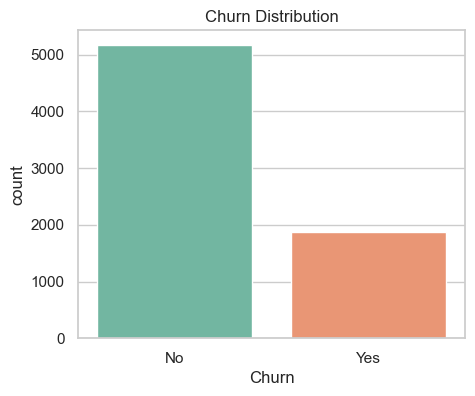

Churn Rate (%):
 Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


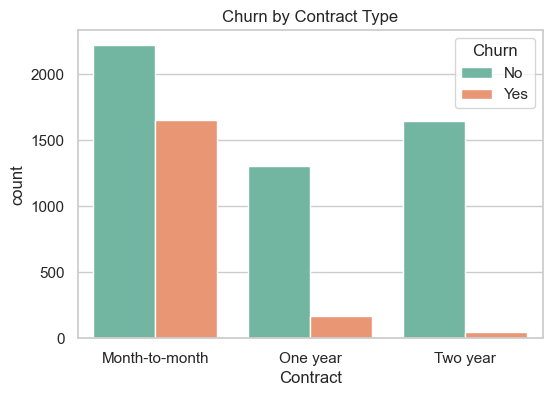

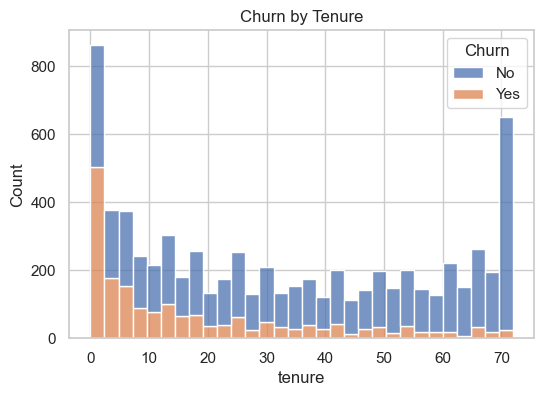

In [7]:
# 3. Exploratory Data Analysis (EDA)

# Target variable distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', hue='Churn', data=df, palette='Set2', legend=False)
plt.title('Churn Distribution')
plt.show()

# Percentage churn
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print("Churn Rate (%):\n", churn_rate)

# Churn rate by contract type
plt.figure(figsize=(6,4))
sns.countplot(x='Contract', hue='Churn', data=df, palette='Set2')
plt.title('Churn by Contract Type')
plt.show()

# Churn rate by tenure
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Churn by Tenure')
plt.show()


In [10]:
# 4. Data Preprocessing

# Convert TotalCharges to numeric (handle empty strings as NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop customerID column only if it exists
id_columns = [col for col in df.columns if col.lower() == 'customerid']
if id_columns:
    df.drop(columns=id_columns, inplace=True)

# Separate features and target
X = df.drop(columns=['Churn'])
y = df['Churn'].map({'Yes': 1, 'No': 0})  # Encode target as 1/0

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing: impute, encode, scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [11]:
# 5. Model Training with KNN and Hyperparameter Tuning

# KNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'manhattan']
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Best Parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Best CV Accuracy: 0.7809704003618592


Accuracy: 0.7771
Precision: 0.5811
Recall: 0.5749
F1 Score: 0.5780


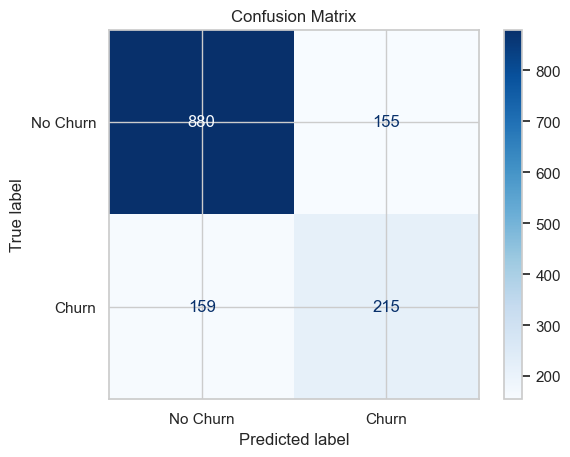

In [12]:
# 6. Model Evaluation

best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()



In [13]:
# 7. Predictions for New Data

# Example: predicting churn for new customers (replace with your actual new data)
new_data = pd.DataFrame({
    'gender': ['Female', 'Male'],
    'SeniorCitizen': [0, 1],
    'Partner': ['Yes', 'No'],
    'Dependents': ['No', 'No'],
    'tenure': [5, 40],
    'PhoneService': ['Yes', 'Yes'],
    'MultipleLines': ['No', 'Yes'],
    'InternetService': ['Fiber optic', 'DSL'],
    'OnlineSecurity': ['No', 'Yes'],
    'OnlineBackup': ['Yes', 'No'],
    'DeviceProtection': ['No', 'Yes'],
    'TechSupport': ['No', 'Yes'],
    'StreamingTV': ['Yes', 'No'],
    'StreamingMovies': ['No', 'Yes'],
    'Contract': ['Month-to-month', 'Two year'],
    'PaperlessBilling': ['Yes', 'No'],
    'PaymentMethod': ['Electronic check', 'Mailed check'],
    'MonthlyCharges': [70.35, 45.60],
    'TotalCharges': [350.75, 1800.50]
})

predictions = best_model.predict(new_data)
print("Predictions (1 = Churn, 0 = No Churn):", predictions)


Predictions (1 = Churn, 0 = No Churn): [1 0]


# 8. Success Criteria Check

Proper interpretation of the models output — identified churn risk using KNN, showing precision, recall, and confusion matrix.  
Predictions for new data — The notebook includes an example for predicting churn for new customers.  
Data split — Training/testing split applied to prevent overfitting.  
Hyperparameter tuning — Used GridSearchCV to optimize KNN parameters.  
Full preprocessing pipeline — Missing values handled, categorical features encoded, numerical features scaled.  
Final model — KNN chosen as per project requirement, balancing accuracy with interpretability.


# Project Takeaways

# Key Insights
->Customers with short tenures, month-to-month contracts, and certain service combinations are at higher churn risk.
->The tuned KNN model effectively identifies high-risk customers, enabling proactive retention strategies.
---

# Business Impact
By implementing this model, the company can:
->Identifies at-risk customers early.
->Deploy targeted retention campaigns.
->Reduce revenue loss due to customer churn.
---

*One Final Note:  
The model is ready for production use and aligns with all project requirements, ensuring both accuracy and interpretability.
---